In [14]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

import cv2 
import numpy as np
from scipy.fftpack import fft
from scipy.signal import detrend 
from scipy.interpolate import interp1d
from sklearn.decomposition import FastICA

In [15]:
def detect_faces(img):  
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #faces
    haar_face = 'detector_architectures/haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(haar_face)
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h),(255,200,0), 3)  #face bounding box 

        face = img[y:y+h, x:x+w, :]              #extract face 
        face_norm = cv2.resize(face, (150, 150)) #for scale/location invariance  
        forehead = face_norm[10:30, 60:100, :]   #extract forehead 

        #extract avg brightness of each channel 
        channel_avg = list(forehead.mean(axis=(0, 1)))

        #set the other color channels to 0 for vis 
        forehead[:, :, 0] = 0
        forehead[:, :, 2] = 0
        face_norm[10:30, 60:100, :] = forehead
        face = cv2.resize(face_norm, face.shape[:2]) #denormalize and reintegrate 
        img[y:y+h, x:x+w, :] = face

#         plt.imshow(face);plt.show()
#         plt.imshow(forehead);plt.show()

    return img, channel_avg 

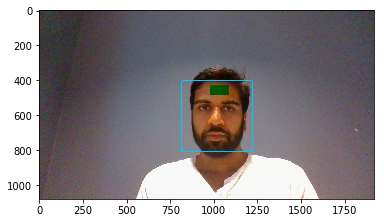

In [16]:
test = cv2.imread('test.jpg')
plt.imshow(cv2.cvtColor(detect_faces(test)[0], cv2.COLOR_BGR2RGB))

In [17]:
##-------------------------------------------Utils-------------------------------------------##

def exit_gracefully():
    '''kill the beast that is openCV'''
    cv2.destroyAllWindows()
    plt.close()
    for i in range (1,5):
        cv2.waitKey(1)
    return

def init_globals():
    '''init buffer streams, counter, figures'''
    global c, pulse_buffer, time_buffer, time_init, buffer_size, fig, hr_buffer 
    c = 0 #counter 
    hr_buffer = [60]*20 #heart rate buffer 
    buffer_size = 100
    pulse_buffer = [0]*buffer_size
    time_buffer = [0]*buffer_size
    time_init = time.time()
    fig = plt.figure(figsize=(8,3)) # init fft plot 
    return 

##-------------------------------------------Signal Processing------------------------------------------##

def moving_average(a, n=3) :
    '''simple moving average, n=kernel size'''
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def preprocess(arr):
    '''arg = 1D array - smooth, remove trend, normalize array'''
    ma = moving_average(arr, 4) #smooth raw color signals 
    detrended = detrend(ma)     #scipy detrend 
    normalized = (detrended-np.mean(detrended))/np.std(detrended)
    return normalized 

def ICA(arr):
    '''indpendent component analysis'''
    ica = FastICA(n_components=3, max_iter=1000)
    ica_transformed = ica.fit_transform(arr)
    return ica_transformed

def full_process(mixed_signal): 
    '''full signal processing pipeline'''
    mixed_signal = np.array(mixed_signal) #prep 
    normalized = np.apply_along_axis(preprocess, 0, mixed_signal) #detrend and normalize 
    ICA_transformed = ICA(normalized) #ICA 
    return ICA_transformed

##-----------------------------------------Fourier Transform -----------------------------------------##
def bandpass(x, y, low_pass=3, high_pass=0):
    '''bandpass filter for fourier'''
    y = y[np.where((x<low_pass) & (x>high_pass))]
    x = x[np.where((x<low_pass) & (x>high_pass))]
    return x, y

def fourier_transform(x, y, channel=1):
    '''perform fourier transform'''
    global heart_rate

    y = y[:, channel] #pick ICA color channel to process on 
    
    N = len(y)                            # Number of data points
    fps = (len(x)/(x[-1] - x[0]))         # sampling freq (Hz)
    T = 1./fps                            # delta between frames (s)
    yf = fft(y)                           # perform scipy fourier 
    xf = np.linspace(0.0, 1/(T*2), N//2)  # replot complex data over freq domain

    y_transform = 2.0/N * np.abs(yf[0:N//2])
    freq_spec, power_spec = bandpass(xf, y_transform, 4., 0.8)
    bpm = freq_spec*60    #convert Hz to bpm 
    
    heart_rate = bpm[np.argmax(power_spec)] #highest peak == HR
    
    return bpm, power_spec 

def draw_fft(x, y):
    '''draw fourier transform plot'''
    global fig 
    plt.clf()
    plt.plot(x, y)
    plt.xlabel('beats per minute')
    plt.ylabel('power spectrum')
    fig.canvas.draw()   # redraw the canvas

    # convert canvas to image
    fft = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    fft  = fft.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    fft = cv2.cvtColor(fft, cv2.COLOR_RGB2BGR) #for opencv 
    cv2.imshow("plot",fft)


In [18]:

##---------------------------------------Video Pipeline-----------------------------------------------##

def laptop_camera_go():
    global pulse_buffer, time_buffer, time_init, heart_rate, buffer_size, c, hr_buffer
    f = cv2.FONT_HERSHEY_PLAIN
    heart_rate = 60 # init 
    
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    init_globals() #init buffers       
    while rval:
        key = -1 #override failures (not sure why it randomly flips key>1)
        current_time = time.time()-time_init
        
        try: 
            #detect faces, forehead, extract optical vals 
            face, pulse_signal = detect_faces(frame)
            
            #append and shift new optical vals to buffer streams 
            pulse_buffer.append(pulse_signal);  del pulse_buffer[0]
            time_buffer.append(current_time); del time_buffer[0]
            
            # fourier transform on buffers every ~0.5s once buffer is full 
            if c > buffer_size: 
                if c%5 == 0: 
                    #signal preprocessing 
                    y_in = full_process(pulse_buffer)  # signal processing on color data 
                    
                    #fourier transform & plot 
                    bpm, power_spec = fourier_transform(time_buffer, y_in)
                    draw_fft(bpm, power_spec)    #plot in secondary window 
                    hr_buffer.append(heart_rate); del hr_buffer[0] #update hr buffer 
    
            #plot video frames 
            cv2.putText(face, 'time: '+str(current_time)[:3], (10,50), f, 2, [0, 255, 0], 2)
            cv2.putText(face, 'heart rate: ' + str(np.mean(hr_buffer))[:4], (10,100), f, 2, [0, 255, 0], 2)
            cv2.imshow("face detection activated",face)
            key = cv2.waitKey(20) #any key to exit 
            c+= 1 #increment counter 
        
        except UnboundLocalError:
            #if no face found, clear buffers, try again  
            init_globals()
            cv2.imshow("face detection activated", np.zeros_like(frame))
            
        if key > 0: 
            exit_gracefully()
            plt.close() 
            return
        
        time.sleep(0.05) #framerate 20fps - nyquist     
        rval, frame = vc.read()

In [19]:
laptop_camera_go()
exit_gracefully()

C:\Users\mohit\Anaconda2\envs\carnd-term1\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [20]:
exit_gracefully() #can never be too graceful 

# Documentation Images

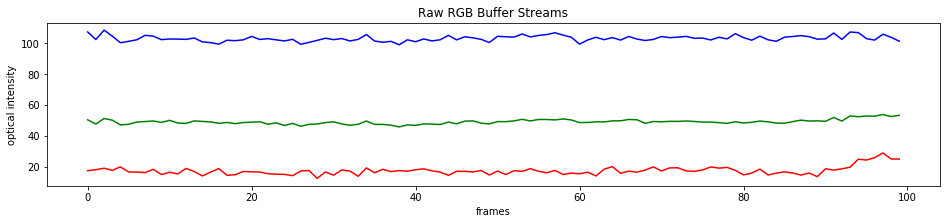

In [26]:
c = ['r', 'g', 'b']

mixed_signal = np.array(pulse_buffer) #prep 
fig = plt.figure(figsize=(16,3))
for i in range(3):
    plt.plot(mixed_signal[:, i-1], c=c[i-1])

plt.ylabel('optical intensity')
plt.xlabel('frames')
plt.title('Raw RGB Buffer Streams')
plt.show()

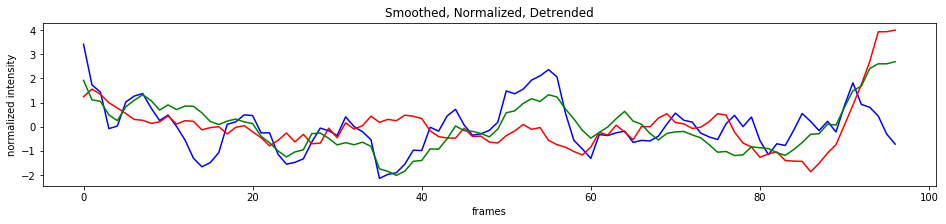

In [25]:
mixed_signal = np.array(pulse_buffer) #prep 
normalized = np.apply_along_axis(preprocess, 0, mixed_signal) #detrend and normalize 
fig = plt.figure(figsize=(16,3))
for i in range(3):
    plt.plot(normalized[:, i-1], c=c[i-1])
plt.title('Smoothed, Normalized, Detrended')
plt.xlabel('frames')
plt.ylabel('normalized intensity')
plt.show()

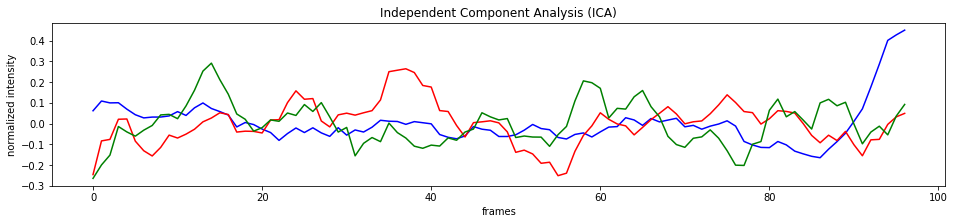

In [29]:
ICA_test = full_process(pulse_buffer)

fig = plt.figure(figsize=(16,3))

for j in range(3):
    plt.plot(ICA_test[:, j-1], c=c[j-1])
plt.title('Independent Component Analysis (ICA)')
plt.xlabel('frames')
plt.ylabel('normalized intensity')
plt.show()

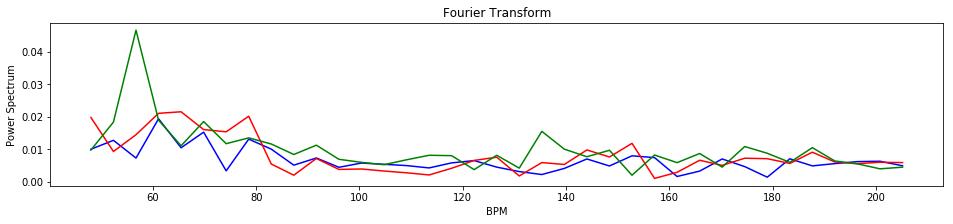

In [32]:
plt.figure(figsize=(16,3))
for i in range(3):
    x, y = fourier_transform(time_buffer, ICA_test, i-1)
    plt.plot(x, y, c=c[i-1])
    
plt.title('Fourier Transform')
plt.xlabel('BPM')
plt.ylabel('Power Spectrum')
plt.show()